In this notebook we learn about how to incorporate Differential Privacy in a naive Bayes Classsifier model. 
Here we also see how the accuracy differs between an ordinary Naive Bayes model and a Naive Bayes model
having Differential Privacy. 

Then we conclude how to achieve a right trade-off between accuracy and privacy, by varying different values of epsilon.
This example works on with scikit-learn-1.2.0 scipy-1.9.3

# Naive Bayes with differential privacy

We start by importing the required libraries and modules and collecting the data that we need from the [Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult).

In [1]:
import diffprivlib.models as dp
import numpy as np
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

In [2]:
X_train = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                        usecols=(0, 4, 10, 11, 12), delimiter=", ")

y_train = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                        usecols=14, dtype=str, delimiter=", ")

Let's also collect the test data from Adult to test our models once they're trained.

In [3]:
X_test = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
                        usecols=(0, 4, 10, 11, 12), delimiter=", ", skiprows=1)

y_test = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
                        usecols=14, dtype=str, delimiter=", ", skiprows=1)
# Must trim trailing period "." from label
y_test = np.array([a[:-1] for a in y_test])

## Naive Bayes with no privacy

To begin, let's first train a regular (non-private) naive Bayes classifier, and test its accuracy.

In [4]:
nonprivate_clf = GaussianNB()
nonprivate_clf.fit(X_train, y_train)

GaussianNB()

In [5]:
print("Non-private test accuracy: %.2f%%" % 
     (nonprivate_clf.score(X_test, y_test) * 100))

Non-private test accuracy: 79.64%


## Differentially private naive Bayes classification

Using the `models.GaussianNB` module of diffprivlib, we can train a naive Bayes classifier while satisfying differential privacy.

If we don't specify any parameters, the model defaults to `epsilon = 1` and selects the model's feature bounds from the data. This throws a warning with `.fit()` is first called, as it leaks additional privacy. To ensure no additional privacy loss, we should specify the bounds as an argument, and choose the bounds indepedently of the data (i.e. using domain knowledge).

In [6]:
dp_clf = dp.GaussianNB()

If you re-evaluate this cell, the test accuracy will change. This is due to the randomness introduced by differential privacy. Nevertheless, the accuracy should be in the range of 87–93%.

In [7]:
dp_clf.fit(X_train, y_train)

print("Differentially private test accuracy (epsilon=%.2f): %.2f%%" % 
      (dp_clf.epsilon, dp_clf.score(X_test, y_test) * 100))

Differentially private test accuracy (epsilon=1.00): 79.53%


/opt/anaconda3/lib/python3.8/site-packages/diffprivlib/models/naive_bayes.py:99: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "


By setting `epsilon=float("inf")` we get an identical model to the non-private naive Bayes classifier.

In [8]:
dp_clf = dp.GaussianNB(epsilon=float("inf"), bounds=(-1e5, 1e5))
dp_clf.fit(X_train, y_train)

print("Agreement between non-private and differentially private (epsilon=inf) classifiers: %.2f%%" % 
     (dp_clf.score(X_test, nonprivate_clf.predict(X_test)) * 100))

Agreement between non-private and differentially private (epsilon=inf) classifiers: 100.00%


## Changing `epsilon`

On this occasion, we're going to specify the `bounds` parameter as a list of tuples, indicating the ranges in which we expect each feature to lie.

In [9]:
bounds = ([17, 1, 0, 0, 1], [100, 16, 100000, 4500, 100])

We will also specify a value for `epsilon`. High `epsilon` (i.e. greater than 1) gives better and more consistent accuracy, but less privacy. Small `epsilon` (i.e. less than 1) gives better privacy but worse and less consistent accuracy.

In [10]:
dp_clf2 = dp.GaussianNB(epsilon=0.1, bounds=bounds)

dp_clf2.fit(X_train, y_train)

GaussianNB(accountant=BudgetAccountant(spent_budget=[(1.0, 0), (inf, 0), (0.1, 0)]),
           bounds=(array([17.,  1.,  0.,  0.,  1.]),
                   array([1.0e+02, 1.6e+01, 1.0e+05, 4.5e+03, 1.0e+02])),
           epsilon=0.1)

In [11]:
print("Differentially private test accuracy (epsilon=%.2f): %.2f%%" % 
     (dp_clf2.epsilon, dp_clf2.score(X_test, y_test) * 100))

Differentially private test accuracy (epsilon=0.10): 77.30%


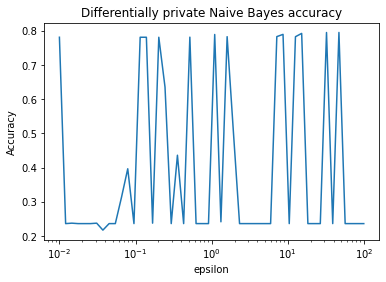

In [12]:
epsilons = np.logspace(-2, 2, 50)
bounds = ([4.3, 2.0, 1.1, 0.1, 0.1], [7.9, 4.4, 6.9, 2.5, 0.1])
accuracy = list()

for epsilon in epsilons:
    clf = dp.GaussianNB(bounds=bounds, epsilon=epsilon)
    clf.fit(X_train, y_train)

    accuracy.append(clf.score(X_test, y_test))

plt.semilogx(epsilons, accuracy)
plt.title("Differentially private Naive Bayes accuracy")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.show()